In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

# Carregar os datasets tratados

In [3]:
data_df = pd.read_csv('/home/gabipereira/EvolucaoDaMusica-BI/data/data.csv')
musicdata_df = pd.read_csv('/home/gabipereira/EvolucaoDaMusica-BI/data/musicdata.csv')
charts_df = pd.read_csv('/home/gabipereira/EvolucaoDaMusica-BI/data/charts.csv')

# Visualização de popularidade das músicas ao longo dos anos

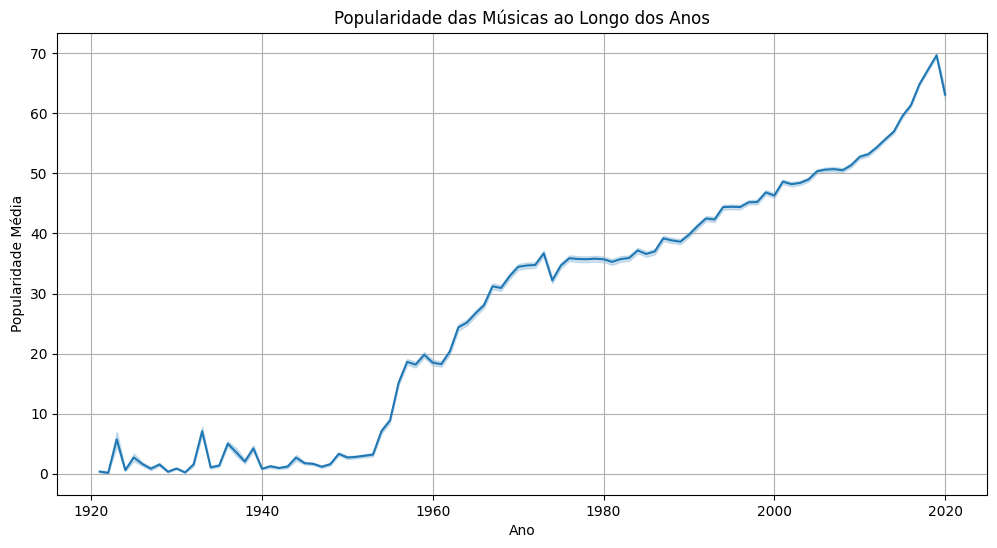

In [4]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data_df, x='year', y='popularity')
plt.title('Popularidade das Músicas ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Popularidade Média')
plt.grid(True)
plt.show()

# Visualização dos picos de diferentes formatos de mídia

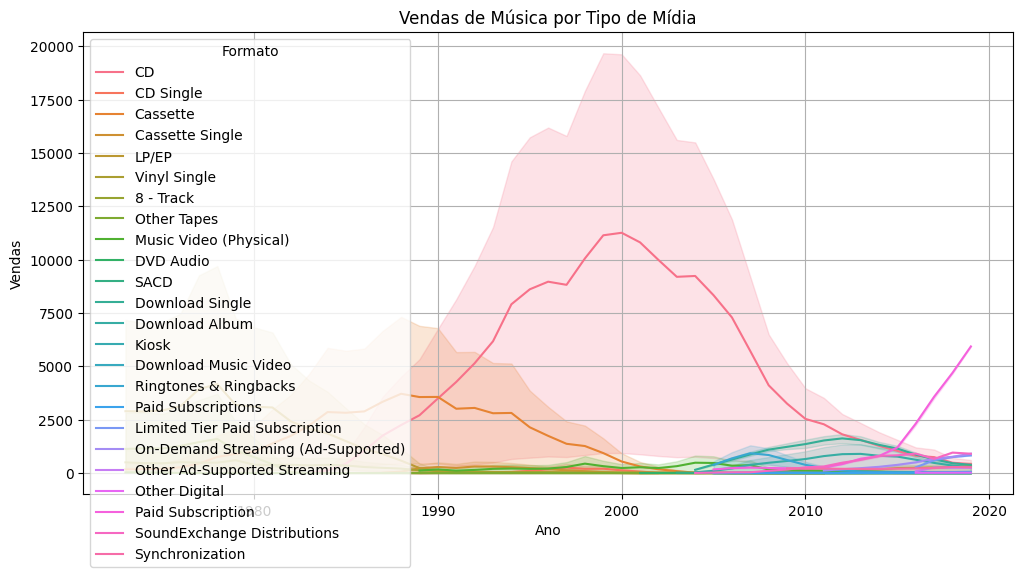

In [5]:
plt.figure(figsize=(12,6))
sns.lineplot(data=musicdata_df, x='year', y='value_actual', hue='format')
plt.title('Vendas de Música por Tipo de Mídia')
plt.xlabel('Ano')
plt.ylabel('Vendas')
plt.grid(True)
plt.legend(title='Formato')
plt.show()

# Visualização dos rankings do Billboard Hot 100
A Billboard Hot 100 é uma parada musical que classifica as 100 músicas mais populares nos Estados Unidos. O ranking é determinado por uma combinação de vendas físicas e digitais, execuções em rádio e streaming. A posição número 1 é a mais alta, significando a música mais popular da semana, e a posição 100 é a mais baixa.

/tmp/ipykernel_151459/1233350390.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=charts_df, x='date', y='rank', ci=None)


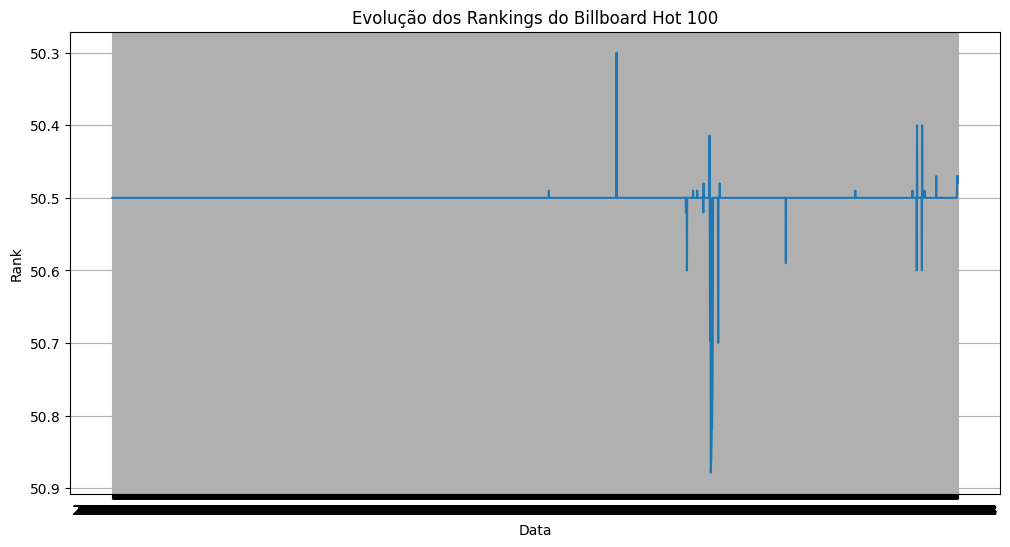

In [14]:
plt.figure(figsize=(12,6))
sns.lineplot(data=charts_df, x='date', y='rank', ci=None)
plt.gca().invert_yaxis()  # Inverte o eixo Y para que o ranking 1 esteja no topo
plt.title('Evolução dos Rankings do Billboard Hot 100')
plt.xlabel('Data')
plt.ylabel('Rank')
plt.grid(True)
plt.show()